<a href="https://colab.research.google.com/github/alina-bogdanovskaya/Data-Analysis_May2022/blob/lesson3/Data_Analysis_lesson3_log_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [202]:
%matplotlib inline
import random
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn import datasets
from matplotlib.colors import ListedColormap

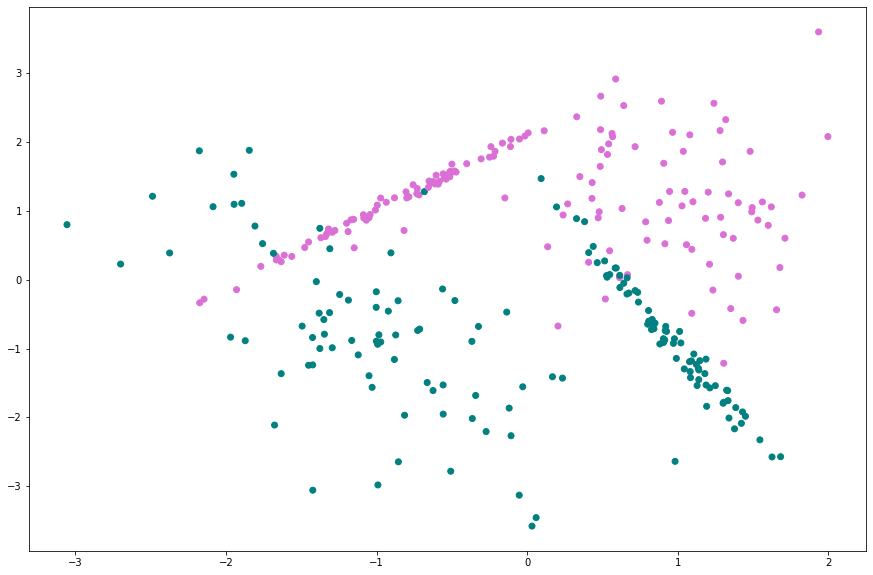

In [203]:
my_classes = datasets.make_classification(n_samples=300, n_features=2, n_informative=2, 
                                          n_redundant=0, n_classes=2, random_state=12)

colors = ListedColormap(['teal', 'orchid'])

plt.figure(figsize=(15, 10))
plt.scatter([x[0] for x in my_classes[0]], 
            [x[1] for x in my_classes[0]], 
            c=my_classes[1], cmap=colors)

In [204]:
np.random.seed(7)
shuffle_index = np.random.permutation(my_classes[0].shape[0])
X_shuffled, y_shuffled = my_classes[0][shuffle_index], my_classes[1][shuffle_index]

train_proportion = 0.7
train_test_cut = int(len(my_classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива обучающей выборки", X_train.shape)
print("Размер массива тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива обучающей выборки (210, 2)
Размер массива тестовой выборки (90, 2)
Размер массива ответов для обучающей выборки (210,)
Размер массива ответов для тестовой выборки (90,)


In [205]:
class logistic_regression:
    def __init__(self, n_iterations=1000, eta=0.05):
        self.n_iterations = n_iterations
        self.eta = eta
    
    def _log_loss_and_grad(self, X, target):
        m = X.shape[0]
        y = (2 * target - 1) # margin M_i = y*(w_i x_i): -1 или 1
        score = (X @ self.w.T).flatten() + self.w0 # степень уверенности, что объект принадлежит классу: от -1 до 1
        loss = np.sum(np.log(1 + np.exp(-y * score)))/m
        Z = -y/(m * (1 + np.exp(y * score))) # градиент для интерцепта
        grad = Z[np.newaxis, :].dot(X)
        return grad/m, np.sum(Z)/m, loss
    
    def _optimize(self, X, target):
        self.losses = []
        for i in range(self.n_iterations):        
            grad_w, grad_w0, loss = self._log_loss_and_grad(X, target)
            self.w = self.w - self.eta * grad_w
            self.w0 = self.w0 - self.eta * grad_w0
            self.losses.append(loss)
    
    def fit(self, X, target):
        self.w = np.zeros((1, X.shape[1]))
        self.w0 = 0
        self._optimize(X, target)
    
    def predict_proba(self, X):  
        score = (X @ self.w.T).flatten() + self.w0
        return 1/(1 + np.exp(-score))
    
    def predict(self, X, thr=0.5):
        proba = self.predict_proba(X)
        y_predicted = np.zeros(proba.shape) 
        y_predicted[proba>thr] = 1
        y_predicted[proba<=thr] = 0
        return y_predicted

    @staticmethod
    def confusion(predicted, actual):
        TP = np.sum(np.logical_and(predicted==1, actual==1))
        FP = np.sum(np.logical_and(predicted==1, actual==0))
        FN = np.sum(np.logical_and(predicted==0, actual==1))
        TN = np.sum(np.logical_and(predicted==0, actual==0))
        return {'TP': TP, 'FP': FP, 'FN': FN, 'TN': TN}

In [206]:
model_log_regression = logistic_regression(n_iterations = 10000, eta = 0.05)

In [207]:
model_log_regression.fit(X_train, y_train)
w, losses = model_log_regression.w, model_log_regression.losses

y_predicted_test = model_log_regression.predict(X_test, thr = 0.5)
y_predicted_train = model_log_regression.predict(X_train, thr = 0.5)

# В качестве меры точности возьмем долю правильных ответов
train_accuracy = 100.0 - np.mean(np.abs(y_predicted_train - y_train)*100.0)
test_accuracy = 100.0 - np.mean(np.abs(y_predicted_test - y_test)*100.0)

print(f"Итоговый вектор весов w: {w}, интерцепт w0: {model_log_regression.w0}")
print(f"Точность на обучающей выборке: {train_accuracy:.3f}")
print(f"Точность на тестовой выборке: {test_accuracy:.3f}")
print(f"Уравнение прямой y = {w[0,0]/w[0,1]}*x + {model_log_regression.w0/w[0,1]}")

Итоговый вектор весов w: [[0.1034167  0.71538739]], интерцепт w0: -0.027245257657244153
Точность на обучающей выборке: 81.429
Точность на тестовой выборке: 93.333
Уравнение прямой y = 0.14456042134237249*x + -0.03808462090673587


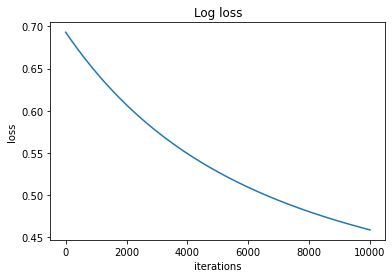

In [208]:
plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.plot(range(len(losses)), losses)

Рассчитаем показатели модели для различных порогов вероятности

In [209]:
confusion_05 = logistic_regression.confusion(model_log_regression.predict(X_test), y_test)
confusion_05

{'FN': 2, 'FP': 4, 'TN': 43, 'TP': 41}

In [210]:
recall = confusion_05['TP']/(confusion_05['TP'] + confusion_05['FN']) # True Positive Rate (sensitivity)
specificity = confusion_05['TN']/(confusion_05['TN'] + confusion_05['FP'])
balanced_accuracy = (recall + specificity)/2
precision = confusion_05['TP']/(confusion_05['TP'] + confusion_05['FP'])
f1_score = 2 * precision * recall/(precision + recall)
print(f"Для порога по вероятности 0.5 на тестовой выборке имеем: \n  точность {precision: .3f}, \n  полноту {recall: .3f}, \n  специфичность {specificity: .3f}, " + 
f"\n  сбалансированную точность {balanced_accuracy: .3f}, \n  гармоническое {f1_score: .3f}")

Для порога по вероятности 0.5 на тестовой выборке имеем: 
  точность  0.911, 
  полноту  0.953, 
  специфичность  0.915, 
  сбалансированную точность  0.934, 
  гармоническое  0.932


In [211]:
confusion_04 = logistic_regression.confusion(model_log_regression.predict(X_test, 0.4), y_test)
confusion_04

{'FN': 1, 'FP': 13, 'TN': 34, 'TP': 42}

In [212]:
recall = confusion_04['TP']/(confusion_04['TP'] + confusion_04['FN']) # True Positive Rate (sensitivity)
specificity = confusion_04['TN']/(confusion_04['TN'] + confusion_04['FP'])
balanced_accuracy = (recall + specificity)/2
precision = confusion_05['TP']/(confusion_05['TP'] + confusion_05['FP'])
f1_score = 2 * precision * recall/(precision + recall)
print(f"Для порога по вероятности 0.4 на тестовой выборке имеем: \n  точность {precision: .3f}, \n  полноту {recall: .3f}, \n  специфичность {specificity: .3f}, " + 
f"\n  сбалансированную точность {balanced_accuracy: .3f}, \n  гармоническое {f1_score: .3f}")

Для порога по вероятности 0.4 на тестовой выборке имеем: 
  точность  0.911, 
  полноту  0.977, 
  специфичность  0.723, 
  сбалансированную точность  0.850, 
  гармоническое  0.943


In [213]:
confusion_06 = logistic_regression.confusion(model_log_regression.predict(X_test, 0.6), y_test)
confusion_06

{'FN': 10, 'FP': 2, 'TN': 45, 'TP': 33}

In [214]:
recall = confusion_06['TP']/(confusion_06['TP'] + confusion_06['FN']) # True Positive Rate (sensitivity)
specificity = confusion_06['TN']/(confusion_06['TN'] + confusion_06['FP'])
balanced_accuracy = (recall + specificity)/2
precision = confusion_06['TP']/(confusion_06['TP'] + confusion_06['FP'])
f1_score = 2 * precision * recall/(precision + recall)
print(f"Для порога по вероятности 0.6 на тестовой выборке имеем: \n  точность {precision: .3f}, \n  полноту {recall: .3f}, \n  специфичность {specificity: .3f}, " + 
f"\n  сбалансированную точность {balanced_accuracy: .3f}, \n  гармоническое {f1_score: .3f}")

Для порога по вероятности 0.6 на тестовой выборке имеем: 
  точность  0.943, 
  полноту  0.767, 
  специфичность  0.957, 
  сбалансированную точность  0.862, 
  гармоническое  0.846


Построим AUC-ROC и AUC-PR

In [215]:
order = np.argsort(model_log_regression.predict_proba(X_test))
order

array([ 2,  3, 40, 77, 65, 35, 59, 30,  6, 76, 11, 22,  0,  7, 79, 70, 72,
       73, 16, 43, 67,  5, 75, 25, 29, 46, 53, 74, 20, 23, 49, 34, 52, 37,
       84, 61, 51, 33, 18, 38, 50, 47, 71, 41, 14, 68, 58, 17, 88, 10, 82,
       85, 28, 54, 45, 39, 32, 57, 78, 62, 36, 31, 87, 64, 66, 26, 21, 44,
       27, 55,  4, 15, 19,  8, 42, 48, 83,  1, 13, 80, 12, 56, 81, 63, 86,
       69, 60,  9, 24, 89])

In [216]:
y_sorted = y_test[order]
y_sorted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [217]:
bins_pos = y_sorted
bins_neg = 1 - y_sorted
num_pos, num_neg = np.sum(bins_pos), np.sum(bins_neg)
print(f'{num_pos} объектов позитивного класса, {num_neg} объектов негативного класса')

43 объектов позитивного класса, 47 объектов негативного класса


In [218]:
TPR = np.concatenate([[0], np.cumsum(bins_neg)/num_neg])

FPR = np.concatenate([[0], np.cumsum(bins_pos)/num_pos])

# TPR, FPR

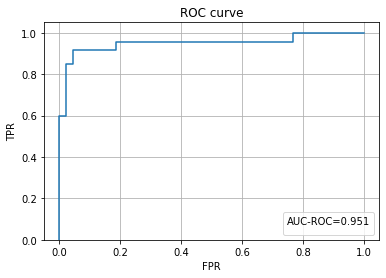

In [219]:
AUC_ROC = np.sum((FPR[1:]-FPR[:-1])*(TPR[1:]+TPR[:-1])/2)

plt.title('ROC curve')
plt.ylim(0, 1.05)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()
plt.legend(' ', title=f'AUC-ROC={AUC_ROC:.3f}', loc='lower right')
plt.plot(FPR, TPR)

In [220]:
precision = np.cumsum(bins_neg)/(np.cumsum(bins_neg)+np.cumsum(bins_pos))
recall = TPR

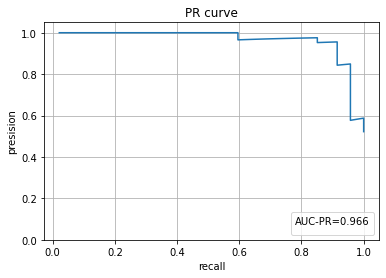

In [221]:
AUC_PR = np.sum(precision*(recall[1:]-recall[:-1]))

plt.title('PR curve')
plt.ylim(0, 1.05)
plt.xlabel('recall')
plt.ylabel('presision')
plt.grid()
plt.legend(' ', title=f'AUC-PR={AUC_PR:.3f}', loc='lower right')
plt.plot(recall[1:], precision)